# Quantum Hadamard Edge Detection for Image Processing

Based on the paper: "Edge Detection Quantumized: A Novel Quantum Algorithm for Image Processing" [https://arxiv.org/html/2404.06889v1 ](https://arxiv.org/html/2404.06889v1) 

This notebook demonstrates:
1. **QPIE (Quantum Probability Image Encoding)** encoding
2. **QHED (Quantum Hadamard Edge Detection)** algorithm

The encoding was implemented based on this paper: [https://arxiv.org/pdf/1801.01465](https://arxiv.org/pdf/1801.01465)

In [70]:
import math
from typing import List

import matplotlib.pyplot as plt
import numpy as np

from classiq import *

[0.0, 0.11764705882352941, 0.23529411764705882, 0.35294117647058826, 0.47058823529411764, 0.5882352941176471, 0.7058823529411765, 0.8235294117647058, 1.0]
[[[0.03921569 0.03921569 0.03921569]
  [0.03921569 0.03921569 0.03921569]
  [0.03921569 0.03921569 0.03921569]
  ...
  [0.04313726 0.04313726 0.04313726]
  [0.04705882 0.04705882 0.04705882]
  [0.04705882 0.04705882 0.04705882]]

 [[0.03921569 0.03921569 0.03921569]
  [0.03921569 0.03921569 0.03921569]
  [0.03921569 0.03921569 0.03921569]
  ...
  [0.04705882 0.04705882 0.04705882]
  [0.04313726 0.04313726 0.04313726]
  [0.04705882 0.04705882 0.04705882]]

 [[0.03921569 0.03921569 0.03921569]
  [0.03921569 0.03921569 0.03921569]
  [0.03921569 0.03921569 0.03921569]
  ...
  [0.04705882 0.04705882 0.04705882]
  [0.04705882 0.04705882 0.04705882]
  [0.04705882 0.04705882 0.04705882]]

 ...

 [[0.03529412 0.03529412 0.02745098]
  [0.02352941 0.02352941 0.01960784]
  [0.02352941 0.02352941 0.01568628]
  ...
  [0.2784314  0.11764706 0.17254

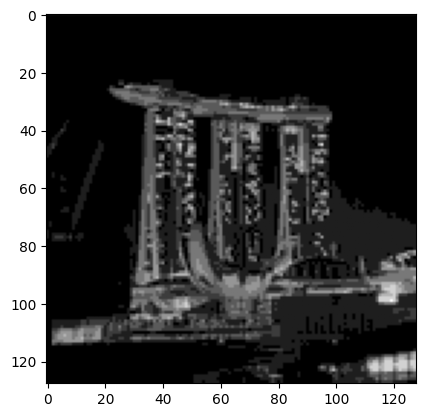

In [71]:
photo = []
photo = plt.imread("Marina Bay Sands 128.png")

plt.imshow(photo)

segments = [i / 255 for i in [0, 30, 60, 90, 120, 150, 180, 210, 255]]
image = np.array(photo)
print(segments)
print(image)
for i in range(1, len(image)):
    for j in range(len(image[i])):
        pixel = image[i][j][0]
        for s in segments:
            if pixel >= s:
                image[i][j][0] = s
                image[i][j][1] = s
                image[i][j][2] = s
print("AFTER THE UPDATE")
print(image)
plt.imshow(image)
image = np.array(photo)

## QPIE Encoding Implementation



In [72]:
def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    Normalize image pixels to create valid probability amplitudes.

    For QPIE, the image is represented as:
    |img⟩ = Σ(x,y) (I_xy / √(Σ I_xy²)) |xy⟩

    Args:
        image: Input image as numpy array

    Returns:
        Normalized probability amplitudes
    """
    # Flatten the image
    flat_image = image.flatten()

    # Normalize to get probability amplitudes
    # Ensure all values are non-negative
    flat_image = np.abs(flat_image)

    # Calculate normalization factor
    norm_factor = np.sqrt(np.sum(flat_image**2))

    if norm_factor == 0:
        # Handle edge case of all-zero image
        normalized = np.ones_like(flat_image) / np.sqrt(len(flat_image))
    else:
        normalized = flat_image / norm_factor

    return normalized


def image_to_qpie_amplitudes(image: np.ndarray) -> List[float]:
    """
    Convert an image to QPIE probability amplitudes.

    Args:
        image: Input image (grayscale or color)

    Returns:
        List of normalized probability amplitudes
    """
    if len(image.shape) == 3:  # Color image
        # Convert to grayscale
        image = np.mean(image, axis=2)

    # Normalize the image
    amplitudes = normalize_image(image)

    return amplitudes.tolist()


@qfunc
def qpie_encoding(image_qubits: Output[QArray[QBit]]):
    """
    QPIE (Quantum Probability Image Encoding) implementation.

    Encodes image pixels as probability amplitudes:
    |img⟩ = Σ c_i |i⟩

    where c_i are normalized pixel values.

    Args:
        amplitudes: Normalized pixel values as probability amplitudes
        image_qubits: Output qubits storing the encoded image
    """
    # Calculate number of qubits needed
    num_pixels = len(AMPLITUDES)
    num_qubits = math.ceil(math.log2(num_pixels))

    # Allocate qubits for image encoding
    allocate(num_qubits, image_qubits)

    # Use inplace_prepare_amplitudes to encode the amplitudes
    inplace_prepare_amplitudes(AMPLITUDES, 0, image_qubits)

## FRQI Encoding Implementation

While the implementation uses QPIE, it mentions FRQI, and shows how to implement it.

If we were to use it, the implementation was very simple, as you can see in the following example. 

FRQI encodes an image as:
$$|I(\theta)\rangle = \frac{1}{2^n} \sum_{i=0}^{4^n-1} (\cos\theta_i|0\rangle + \sin\theta_i|1\rangle) \otimes |i\rangle$$

Where:
- $\theta_i$ represents the pixel intensity at position $i$
- The first qubit encodes pixel information
- The remaining qubits encode position information

In [73]:
@qfunc
def frqi_encoding_simple(
    angles: CArray[CReal, 4],  # For 2x2 image
    pixel: Output[QBit],
    position: Output[QNum],
):
    """
    FRQI encoding for a 2x2 image (4 pixels).
    Uses 1 pixel qubit + 2 position qubits = 3 qubits total.
    """
    # Allocate qubits
    allocate(1, pixel)
    allocate(2, position)

    # Create superposition of positions
    hadamard_transform(position)

    # Apply controlled rotations for each pixel
    for i in range(angles.len):
        control(position == i, lambda: RY(2 * angles[i], pixel))

In [74]:
amplitudes = image_to_qpie_amplitudes(image)
print(f"{amplitudes=}")

amplitudes=[0.0013527866685763001, 0.0013527866685763001, 0.0013527866685763001, 0.0013527866685763001, 0.001217507990077138, 0.0013527866685763001, 0.0013527866685763001, 0.0014880653470754623, 0.0014880653470754623, 0.0014880653470754623, 0.0013527866685763001, 0.0013527866685763001, 0.0013527866685763001, 0.0014880653470754623, 0.0014880653470754623, 0.0016233439091593027, 0.0014880653470754623, 0.0014880653470754623, 0.0014880653470754623, 0.0013527866685763001, 0.0014880653470754623, 0.0014880653470754623, 0.0014880653470754623, 0.0013527866685763001, 0.0014880653470754623, 0.0014880653470754623, 0.0014880653470754623, 0.0016233439091593027, 0.0014880653470754623, 0.0016233439091593027, 0.0016233439091593027, 0.0014880653470754623, 0.0014880653470754623, 0.0016233439091593027, 0.0014880653470754623, 0.0016233439091593027, 0.0016233439091593027, 0.0014880653470754623, 0.0016233439091593027, 0.001758622587658465, 0.0016233439091593027, 0.001758622587658465, 0.001758622587658465, 0.0

In [75]:
len(amplitudes)

16384

## Modified QHED Algorithm

The QHED algorithm detects edges by:
1. Adding an auxiliary qubit in $|+\rangle$ state
2. Applying amplitude permutation to shift pixels
3. Applying Hadamard to compute differences
4. Measuring to get edge information

In [76]:
@qfunc
def quantum_edge_detection_scalable(
    # n_qubits: CInt,  # Number of position qubits
    edge_aux: Output[QBit],
    position: Output[QNum],
):

    # Allocate qubits
    allocate(1, edge_aux)

    # We use the QPIE encoding to encode the image in the quantum state
    qpie_encoding(image_qubits=position)

    # QHED edge detection
    within_apply(
        within=lambda: H(edge_aux),
        apply=lambda: (
            control(edge_aux, lambda: inplace_add(-1, position)),  # Cyclic shift
        ),
    )

## Synthesize and Analyze the Quantum Circuit

In [77]:
from classiq.qmod.symbolic import logical_or


@qfunc
def quantum_edge_detection_scalable(
    # n_qubits: CInt,  # Number of position qubits
    edge_aux: Output[QBit],
    position: Output[QNum],
):

    # We use the QPIE encoding to encode the image in the quantum state
    qpie_encoding(image_qubits=position)

    # Create the vertical and horizontal correlation checks
    horizontal_edge = QBit()
    vertical_edge = QBit()
    allocate(horizontal_edge)
    allocate(vertical_edge)

    # QHED edge detection
    within_apply(
        within=lambda: H(horizontal_edge),
        apply=lambda: (
            control(
                horizontal_edge, lambda: inplace_add(-1, position)
            ),  # Cyclic shift one left
        ),
    )
    within_apply(
        within=lambda: H(vertical_edge),
        apply=lambda: (
            control(
                vertical_edge, lambda: inplace_add(-n, position)
            ),  # Cyclic shift one up
        ),
    )

    edge_aux |= logical_or(horizontal_edge, vertical_edge)


# Create and synthesize the 2x2 model

AMPLITUDES = amplitudes
n = int(np.sqrt(len(AMPLITUDES)))
print(f"Creating {n}x{n} image edge detection model...")


@qfunc
def main(
    pos: Output[QNum],
    edge_aux: Output[QNum],
):
    quantum_edge_detection_scalable(edge_aux=edge_aux, position=pos)


qmod = create_model(
    main,
    constraints=Constraints(max_width=20),
    preferences=Preferences(timeout_seconds=14400),
)

write_qmod(
    qmod,
    "quantum_image_edge_detection",
    decimal_precision=15,
)

Creating 128x128 image edge detection model...


In [ ]:
qprog = synthesize(
    main,
    constraints=Constraints(max_width=20),
    preferences=Preferences(timeout_seconds=14400),
)

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/Users/barakazar/.pyenv/versions/3.11.7/lib/python3.11/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x1045de3c0> is already entered
Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/Users/barakazar/.pyenv/versions/3.11.7/lib/python3.11/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x1045de3c0> is already entered
Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/Users/barakazar/.pyenv/versions/3.11.7/lib/python3.11/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_con

In [ ]:
print(f"\n{n}x{n} Image Circuit Statistics:")
print(f"  - Number of qubits: {qprog.data.width}")
print(f"  - Circuit depth: {qprog.transpiled_circuit.depth}")
print(
    f"  - Number of gates: {qprog.transpiled_circuit.count_ops if hasattr(qprog.transpiled_circuit, 'count_ops') else 'N/A'}"
)

In [ ]:
show(qprog)

In [ ]:
qprog = set_quantum_program_execution_preferences(
    qprog, preferences=ExecutionPreferences(num_shots=200000)
)
res = execute(qprog).result()[0].value
res.dataframe

## Create edge image from measurement results

In [ ]:
new_amplitudes = dict()
for pos in range(len(AMPLITUDES)):
    new_amplitudes[pos] = 0

num_shots = sum([pc.shots for pc in res.parsed_counts])

# if marked as edge, set new amplitude normalized
for pc in res.parsed_counts:
    if pc.state["edge_aux"] == 1:
        new_amplitudes[pc.state["pos"]] = float(
            np.sqrt(pc.shots / num_shots)
        )  # / (AMPLITUDES[n * i + j])

# set amplitude in image of edges
edge_image = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        edge_image[i, j] = new_amplitudes[n * i + j]

print(
    len(
        list(
            (i, new_amplitudes[i])
            for i in range(len(new_amplitudes))
            if new_amplitudes[i] > 0.0
        )
    )
)

Analyze amplitude distributions

In [ ]:
plt.hist(new_amplitudes.values())

In [ ]:
# edge_image = np.zeros((n, n))
# for i in range(n):
#     for j in range(n):
#         edge_image[i,j] = (new_amplitudes[n* i + j]) / (AMPLITUDES[n * i + j])
#
# print(len(list((i, new_amplitudes[i]) for i in range(len(new_amplitudes)) if new_amplitudes[i] >0.0)))
# plt.imshow(edge_image)#, cmap="gray")

One can see that there are some very small amplitudes that can be ignored to get a cleaner edge image

In [ ]:
edge_image = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        edge_image[i, j] = (
            new_amplitudes[n * i + j] if new_amplitudes[n * i + j] > 0.003 else 0
        )

# print((list((i, new_amplitudes[i]) for i in range(len(new_amplitudes)) if new_amplitudes[i] > 0.005)))

In [ ]:
plt.hist(AMPLITUDES)

In [ ]:
plt.imshow(edge_image)  # , cmap="gray")

In comparison to the original image

In [ ]:
plt.imshow(image)